### Text Scraping

In [555]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import pdfplumber
import requests

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download("stopwords")
# nltk.download("wordnet")

from bs4 import BeautifulSoup

import difflib

from io import BytesIO
import copy

from wordcloud import WordCloud

In [379]:
#load in supreme court database
#replace read_csv file name with your file name and directory
scdf = pd.read_csv("SCDB_2024_01_caseCentered_Citation 2.csv")

['JOHN', 'SMITH']

In [711]:
def extract_argument_transcripts(year):
    """
    Extract all URLs on a given page
    Inputs: 
    - year:int or string

    Outputs:
    - td_df:pd df with case name, date argued, truncated oral arg. string and full oral_arg link
    """
    numyear = year
    styear = str(year)
    url = f"https://www.supremecourt.gov/oral_arguments/argument_transcript/{styear}"
    request = requests.get(url)

    soup = BeautifulSoup(request.text, "html.parser")
    
    td = {"case_names" : [],
          "scdb_match" : [],
          "dateArg" : [],
          "oral_arg" : []}
    #find all links on page
    for link in soup.find_all('a'):
        raw_link = link.get('href')
        string_link = str(raw_link)
        #set different search strings based on SC data storage
        if year >= 2010: 
            search_string = "/argument_transcripts/"
        else:
            search_string = "pdfs/transcripts"
            
        if search_string in string_link:
            casename = link.next_element.next_element.next_element.next_element
            cleaned_casename = str(casename).upper()
            acc_dict = {"FEDERAL ELECTION COMM'N" : "FEDERAL ELECTION COMMISSION",
                       }
            
            casename_list = cleaned_casename.split(" V. ")
            #print(cleaned_casename)
            #print(casename_list)

            date = casename.next_element.next_element.next_element

            cleaned_link = str(raw_link)
            cleaned_link = cleaned_link.replace("..", "")
            #print(cleaned_link)
            
            td["case_names"].append(cleaned_casename)
            td["dateArg"].append(date)
            td["oral_arg"].append(cleaned_link)

            # print(casename)
            # print(raw_link)
            year_df = scdf[scdf["term"] == numyear]
            
            matched_list = difflib.get_close_matches(cleaned_casename, year_df["caseName"], cutoff = 0.5)
            #print(matched_list)
            
            if (len(casename_list) == 2):
                #print("hit")
                casename_list_1 = casename_list[0]
                casename_list_2 = casename_list[1]
                search_string = f"{casename_list_1}|{casename_list_2}"
                #print(search_string)
                
                search = year_df[year_df['caseName'].str.contains(search_string)==True]

                if len(search) != 0:
                    matched_name = search["caseName"].values[0]
                    td["scdb_match"].append(matched_name)
                else:
                    if len(matched_list) != 0:
                        matched_name = matched_list[0]
                        td["scdb_match"].append(matched_name)
                    else:
                        td["scdb_match"].append("NA")
            elif (len(casename_list) != 2) & (len(matched_list) != 0):
                matched_name = matched_list[0]
                td["scdb_match"].append(matched_name)
            else:
                td["scdb_match"].append("NA")
                
            
    td_df = pd.DataFrame(td)
    td_df.insert(0, "year", numyear)

    if numyear >= 2010:
        td_df["full_link"] = "https://www.supremecourt.gov/oral_arguments" + td_df["oral_arg"]
    else:
        td_df["full_link"] = "https://www.supremecourt.gov" + td_df["oral_arg"]
    td_df.replace("NA", pd.NA, inplace = True)
    
    return td_df


In [512]:
def extract_text(url, identifier):
    """
    Use PDF plumber to extract all text
    Inputs:
    -url:str url to extract

    Outputs
    all_text:str all text in the document
    """
    response = requests.get(url)
    if response.status_code == 200:
        document_dict = {"id" : [identifier],
                        "all_text" : []}
        all_text = ""
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            doc = pdf.pages
            for p in doc:
                page_num = p.page_number
                print(f"Extracting Page {page_num}")

               
                if page_num == 1:
                    #get information about speakers
                    text = p.extract_text()
                    #test_text = test_text + text

                    attorneys = re.findall(r"([A-Z].*)(?=, ESQ.)", text)

                    for i, atty in enumerate(attorneys):
                        idx = str(i+1)
                        at_col_name = "attorney_" + idx
                        at_ln_col = "attorney_" + idx + "_LN"

                        split_name = atty.split()
                        ln = split_name[-1]
                        if ln.find(".") != -1:
                            ln = split_name[-2]
                            ln = ln.replace(",", "")
                        
                        document_dict[at_col_name] = [atty]
                        document_dict[at_ln_col] = [ln]
                elif page_num == 2:
                    #skips second page
                    continue
                    
                else:
                    #get all text in a page
                    text = p.extract_text()
    
                    #Do some preliminary cleaning
                    text = text.replace("- -", "")
                    text = text.replace("\'", "")
                    text = re.sub(r'\d+', "", text)
                    text = text.replace("Heritage Reporting Corporation", "")
                    text = text.replace("Official — Subject to Final Review", "")
                    text = text.replace("ALDERSON REPORTING COMPANY, INC.  FOURTEENTH STREET, N.W. SUITE  WASHINGTON, D.C.  ()- () FOR DEPO", "")
                    
                    all_text = all_text + text

            clean_text = re.findall(r'(?:MR\.|MS\.|MRS\.|JUSTICE|CHIEF JUSTICE)\s+[A-Z]+:\s*(.*?)(?=\n (?:MR\.|MS\.|MRS\.|JUSTICE|CHIEF JUSTICE|QUESTION:|$))', all_text, re.DOTALL)
            clean_text = " ".join(clean_text)
            all_text = clean_text.replace("\n", "")
            document_dict["all_text"] = all_text

            df = pd.DataFrame(document_dict)
        return df     
    else:
        errormessage = f"Failed to fetch PDF. Status code: {response.status_code}"
        return errormessage


In [641]:
def extract_text_for_year(dictionary, year, case_name_col = "case_names"):
    print(f"working on {year}\n")
    to_it = dictionary
    to_concat = []

    for i, row in to_it.iterrows():
        url = row["full_link"]
        identifier = row[case_name_col]
        print(identifier)
        text_df = extract_text(url, identifier)
        to_concat.append(text_df)

        
    text_df = pd.concat(to_concat)

    fdf = pd.merge(to_it, text_df, left_on = case_name_col, right_on = "id")

    return fdf

In [712]:
#obtain links of all oral arguments from supreme court website 
oa_storage = {}
years = list(range(2000, 2025, 1))
for yr in years: 
    print(yr)
    doc_name = f"./matched_df/to_match_df_{yr}.csv"
    df = extract_argument_transcripts(yr)
    oa_storage[yr] = df

    df.to_csv(doc_name)

2000


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2001


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2002
2003


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2004
2005


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2006


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2007
2008


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2009
2010
2011


/var/folders/mf/zhnnyffn3wv77d_kx1l8l8hw0000gn/T/ipykernel_8946/2912877783.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  search = year_df[year_df['caseName'].str.contains(search_string)==True]


2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [713]:
#merge oral argument transcript dictionary with supreme court database case vars
oa_dict = {}
for year in oa_storage:
    merged = pd.merge(oa_storage[year], scdf, how = "left", left_on = "scdb_match", right_on = "caseName")
    
    oa_dict[year] = merged

    
oa_dict

{2000:     year                                         case_names  \
 0   2000                               BECKER V. MONTGOMERY   
 1   2000                                      TYLER V. CAIN   
 2   2000                             NEW HAMPSHIRE V. MAINE   
 3   2000                UNITED STATES V. UNITED FOODS, INC.   
 4   2000                                 ALABAMA V. BOZEMAN   
 ..   ...                                                ...   
 76  2000            LEGAL SERVICES CORPORATION V. VELAZQUEZ   
 77  2000                         CLEVELAND V. UNITED STATES   
 78  2000                                   ARTUZ V. BENNETT   
 79  2000  BOARD OF TRUSTEES OF THE UNIV. OF ALA. V. GARRETT   
 80  2000  BRENTWOOD ACADEMY V. TENNESSEE SECONDARY ATHLE...   
 
                                            scdb_match   dateArg  \
 0   DALE G. BECKER v. BETTY MONTGOMERY, ATTORNEY G...  04/16/01   
 1                   MELVIN TYLER v. BURL CAIN, WARDEN  04/16/01   
 2            STATE 

In [716]:
#remove all non-unanimous cases from df
oa_non_unan = {}
sum_non_unan = {"year" : [],
               "number_total" : [],
               "non_unan" : []}

for year in oa_dict:
    df = oa_dict[year]
    new_df = df[(df["majVotes"] != 9) & (df["minVotes"] != 9)]
    
    oa_non_unan[year] = new_df
    
    sum_non_unan["year"].append(year)
    sum_non_unan["number_total"].append(len(df))
    sum_non_unan["non_unan"].append(len(new_df))

summary_df_nonunan = pd.DataFrame(sum_non_unan)
summary_df_nonunan["percentage_nonunan"] =  summary_df_nonunan["non_unan"] / summary_df_nonunan["number_total"]

print(summary_df_nonunan.to_latex(index = False, float_format="%.2f"))


\begin{tabular}{rrrr}
\toprule
year & number_total & non_unan & percentage_nonunan \\
\midrule
2000 & 81 & 38 & 0.47 \\
2001 & 80 & 46 & 0.57 \\
2002 & 77 & 43 & 0.56 \\
2003 & 75 & 38 & 0.51 \\
2004 & 75 & 44 & 0.59 \\
2005 & 79 & 45 & 0.57 \\
2006 & 71 & 47 & 0.66 \\
2007 & 70 & 38 & 0.54 \\
2008 & 80 & 38 & 0.47 \\
2009 & 77 & 48 & 0.62 \\
2010 & 78 & 69 & 0.88 \\
2011 & 73 & 52 & 0.71 \\
2012 & 75 & 50 & 0.67 \\
2013 & 84 & 40 & 0.48 \\
2014 & 89 & 70 & 0.79 \\
2015 & 71 & 66 & 0.93 \\
2016 & 66 & 63 & 0.95 \\
2017 & 66 & 49 & 0.74 \\
2018 & 74 & 50 & 0.68 \\
2019 & 60 & 40 & 0.67 \\
2020 & 67 & 49 & 0.73 \\
2021 & 63 & 39 & 0.62 \\
2022 & 59 & 37 & 0.63 \\
2023 & 61 & 33 & 0.54 \\
2024 & 42 & 42 & 1.00 \\
\bottomrule
\end{tabular}



In [616]:
sum(summary_df_nonunan["number_total"])

sum(summary_df_nonunan["non_unan"])

1350

In [719]:
%%time
yrs = list(range(2000, 2006, 1))
for year in yrs:
    to_it = oa_non_unan[year]
    oas[year] = extract_text_for_year(to_it, year)
        

working on 2000

TYLER V. CAIN
Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Page 50
NEW HAMPSHIRE V. MAINE
Extra

In [720]:
%%time
yrs = list(range(2006, 2011, 1))
for year in yrs:
    to_it = oa_non_unan[year]
    oas[year] = extract_text_for_year(to_it, year)
        

working on 2006

POWEREX CORP. V. RELIANT ENERGY SERVICES, INC.
Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Pag

In [721]:
%%time
yrs = list(range(2011, 2015, 1))
for year in yrs:
    to_it = oa_non_unan[year]
    oas[year] = extract_text_for_year(to_it, year)
        

working on 2011

CHRISTOPHER V. SMITHKLINE BEECHAM CORP.
Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Page 50
Ex

In [722]:
%%time
yrs = list(range(2015, 2021, 1))
for year in yrs:
    to_it = oa_non_unan[year]
    oas[year] = extract_text_for_year(to_it, year)
        

working on 2015

UNITED STATES V. TEXAS
Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Page 50
Extracting Page 51


In [723]:
%%time
yrs = list(range(2021, 2025, 1))
for year in yrs:
    to_it = oa_non_unan[year]
    oas[year] = extract_text_for_year(to_it, year)
        

working on 2021

GEORGE V. MCDONOUGH
Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Page 50
Extracting Page 51
Ext

In [724]:
#save oral arguments as CSV
for year in oas:
    df = oas[year]
    path = "/Users/eclin/Desktop/ML_Project/oral_arg/"
    end = f"arguments{year}.csv"

    file_name = path+end

    df.to_csv(file_name)

In [546]:
oa_dict[2010]["full_link"][46]

'https://www.supremecourt.gov/oral_arguments/argument_transcripts/2010/09-1233.pdf'

In [549]:
text1 = extract_text("https://www.supremecourt.gov/oral_arguments/argument_transcripts/2010/09-1233.pdf", "caseName")

t = copy.deepcopy(text1)
t["processed"] = t["all_text"].map(lambda x: re.sub(r'[,\.!?]', '', x))
t["processed"] = t["processed"].map(lambda x: x.lower())

stop_words = stopwords.words("english")
stop_words.extend(["review", "justice", 
                   "court", "case", 
                   "subject", 
                   "final", "question",
                  "judge",
                  "companyofficial"])

data = t["processed"].values.tolist()
data = [re.sub(r'\W+',' ', data[0])]

resultwords  = [word for word in re.split(r"\W+", data[0]) if word.lower() not in stop_words]
resultwords

Extracting Page 1
Extracting Page 2
Extracting Page 3
Extracting Page 4
Extracting Page 5
Extracting Page 6
Extracting Page 7
Extracting Page 8
Extracting Page 9
Extracting Page 10
Extracting Page 11
Extracting Page 12
Extracting Page 13
Extracting Page 14
Extracting Page 15
Extracting Page 16
Extracting Page 17
Extracting Page 18
Extracting Page 19
Extracting Page 20
Extracting Page 21
Extracting Page 22
Extracting Page 23
Extracting Page 24
Extracting Page 25
Extracting Page 26
Extracting Page 27
Extracting Page 28
Extracting Page 29
Extracting Page 30
Extracting Page 31
Extracting Page 32
Extracting Page 33
Extracting Page 34
Extracting Page 35
Extracting Page 36
Extracting Page 37
Extracting Page 38
Extracting Page 39
Extracting Page 40
Extracting Page 41
Extracting Page 42
Extracting Page 43
Extracting Page 44
Extracting Page 45
Extracting Page 46
Extracting Page 47
Extracting Page 48
Extracting Page 49
Extracting Page 50
Extracting Page 51
Extracting Page 52
Extracting Page 53
Ex

['well',
 'hear',
 'argument',
 'schwarzenegger',
 'v',
 'plata',
 'related',
 'cases',
 'mr',
 'phillips',
 'oral',
 'argument',
 'carter',
 'g',
 'phillips',
 'behalf',
 'appellants',
 'thank',
 'mr',
 'chief',
 'may',
 'please',
 'today',
 'extraordinary',
 'unprecedented',
 'order',
 'issued',
 'three',
 'district',
 'requiring',
 'release',
 'inmates',
 'currently',
 'incarcerated',
 'california',
 'penal',
 'system',
 'within',
 'year',
 'period',
 'order',
 'particular',
 'made',
 'particularly',
 'remarkable',
 'strikes',
 'minimum',
 'extraordinarily',
 'premature',
 'may',
 'come',
 'point',
 'process',
 'order',
 'probably',
 'substantially',
 'smaller',
 'scope',
 'one',
 'may',
 'become',
 'appropriate',
 'supposed',
 'order',
 'remedy',
 'last',
 'resort',
 'district',
 'done',
 'leapfrogged',
 'series',
 'steps',
 'taken',
 'ahead',
 'going',
 'particular',
 'routealderson',
 'reporting',
 'one',
 'mr',
 'phillips',
 'pending',
 'years',
 'yes',
 'thats',
 'correct',
 'g

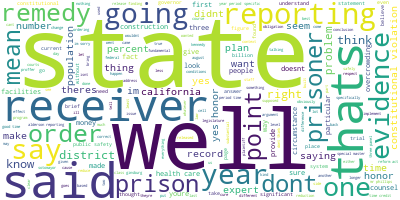

In [550]:
string = ",".join(resultwords)
wordcloud = WordCloud(background_color = "white", max_words = 5000, contour_width = 3, contour_color = "steelblue")
wordcloud.generate(string)
wordcloud.to_image()

In [551]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words= stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(resultwords)  
train_data

# Define the number of topics or components
num_components=2

# Create LDA object
model=LDA(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

terms = tfidf.get_feature_names_out()
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Topic 0:  ['state', 'said', 'would', 'going', 'years']
Topic 1:  ['reporting', 'well', 'thats', 'receiver', 'time']
